In [1]:
# 1. Library Import

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors  # ⬅️ 이 줄 추가


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
# 2. Load Dataset
df = pd.read_csv("./tmQM_y.csv", sep=';')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (108541, 11)
Columns: ['CSD_code', 'Electronic_E', 'Dispersion_E', 'Dipole_M', 'Metal_q', 'HL_Gap', 'HOMO_Energy', 'LUMO_Energy', 'Polarizability', 'CSD_years', 'SMILES']


In [3]:
# 3. Clean Dataset
# df = df[df['SMILES'].notna()].copy()
# df = df[df['SMILES'] != ''].copy()
# print(f"After cleaning: {df.shape}")


# 3.1 Clean Dataset + 분자량 필터링

MW_CUTOFF = 500.0  # ALD 전구체 수준의 작은 분자만 사용 (원하면 숫자 조정)

# 1) SMILES 결측/빈 문자열 제거
df = df[df['SMILES'].notna()].copy()
df = df[df['SMILES'] != ''].copy()
print(f"After cleaning (SMILES not null/empty): {df.shape}")

# 2) 분자량 계산 함수 정의
def calc_mw(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return Descriptors.MolWt(mol)

# 3) 분자량 컬럼 추가
df["MW"] = df["SMILES"].apply(calc_mw)

# SMILES 파싱 실패한 행 제거
df = df[df["MW"].notna()].copy()

# 4) 분자량 기준 필터링 (MW <= 500만 사용)
df = df[df["MW"] <= MW_CUTOFF].copy()

print(f"After MW <= {MW_CUTOFF} filter: {df.shape}")
print(df["MW"].describe())


After cleaning (SMILES not null/empty): (100849, 11)


[03:55:13] WARNING: not removing hydrogen atom without neighbors
[03:55:13] WARNING: not removing hydrogen atom without neighbors
[03:55:13] Explicit valence for atom # 11 P, 6, is greater than permitted
[03:55:13] Explicit valence for atom # 1 As, 5, is greater than permitted
[03:55:13] Explicit valence for atom # 14 P, 6, is greater than permitted
[03:55:13] WARNING: not removing hydrogen atom without neighbors
[03:55:13] WARNING: not removing hydrogen atom without neighbors
[03:55:13] WARNING: not removing hydrogen atom without neighbors
[03:55:14] WARNING: not removing hydrogen atom without neighbors
[03:55:14] WARNING: not removing hydrogen atom without neighbors
[03:55:14] WARNING: not removing hydrogen atom without neighbors
[03:55:14] WARNING: not removing hydrogen atom without neighbors
[03:55:14] WARNING: not removing hydrogen atom without neighbors
[03:55:14] WARNING: not removing hydrogen atom without neighbors
[03:55:15] WARNING: not removing hydrogen atom without neighbor

After MW <= 500.0 filter: (30795, 12)
count    30795.000000
mean       414.268625
std         62.062867
min         95.460000
25%        374.829500
50%        426.324000
75%        464.787000
max        499.984000
Name: MW, dtype: float64


In [4]:
# 4. SMILES를 PyTorch Geometric 그래프로 변환

def smiles_to_graph(smiles):
    """
    SMILES 문자열을 PyTorch Geometric Data 객체로 변환
    
    Node features:
    - Atomic number (one-hot encoded for common elements)
    - Degree
    - Formal charge
    - Hybridization
    - Aromaticity
    - Number of hydrogens
    
    Edge features:
    - Bond type (one-hot encoded)
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        
        # Node features
        atom_features = []
        for atom in mol.GetAtoms():
            # Atomic number (one-hot for common elements)
            atomic_num = atom.GetAtomicNum()
            # Common elements in organic/inorganic chemistry
            common_atoms = [1, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 22, 24, 26, 29, 30, 35, 40, 72, 73]  # H, B, C, N, O, F, Al, Si, P, S, Cl, Ti, Cr, Fe, Cu, Zn, Br, Zr, Hf, Ta
            atomic_num_encoded = [1 if atomic_num == x else 0 for x in common_atoms]
            if atomic_num not in common_atoms:
                atomic_num_encoded.append(1)  # Other
            else:
                atomic_num_encoded.append(0)
            
            # Degree
            degree = atom.GetDegree()
            degree_encoded = [1 if degree == x else 0 for x in range(6)]  # 0-5
            
            # Formal charge
            formal_charge = atom.GetFormalCharge()
            
            # Hybridization
            hybridization = atom.GetHybridization()
            hybridization_encoded = [
                1 if hybridization == Chem.rdchem.HybridizationType.SP else 0,
                1 if hybridization == Chem.rdchem.HybridizationType.SP2 else 0,
                1 if hybridization == Chem.rdchem.HybridizationType.SP3 else 0,
                1 if hybridization == Chem.rdchem.HybridizationType.SP3D else 0,
                1 if hybridization == Chem.rdchem.HybridizationType.SP3D2 else 0,
            ]
            
            # Aromaticity
            is_aromatic = 1 if atom.GetIsAromatic() else 0
            
            # Number of hydrogens
            num_hs = atom.GetTotalNumHs()
            
            # Combine all features
            atom_feature = atomic_num_encoded + degree_encoded + [formal_charge, is_aromatic, num_hs] + hybridization_encoded
            atom_features.append(atom_feature)
        
        x = torch.tensor(atom_features, dtype=torch.float)
        
        # Edge indices and features
        edge_indices = []
        edge_features = []
        
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            
            # Add both directions for undirected graph
            edge_indices.append([i, j])
            edge_indices.append([j, i])
            
            # Bond type encoding
            bond_type = bond.GetBondType()
            bond_feature = [
                1 if bond_type == Chem.rdchem.BondType.SINGLE else 0,
                1 if bond_type == Chem.rdchem.BondType.DOUBLE else 0,
                1 if bond_type == Chem.rdchem.BondType.TRIPLE else 0,
                1 if bond_type == Chem.rdchem.BondType.AROMATIC else 0,
                1 if bond.GetIsConjugated() else 0,
                1 if bond.IsInRing() else 0,
            ]
            
            edge_features.append(bond_feature)
            edge_features.append(bond_feature)  # Same features for reverse edge
        
        if len(edge_indices) == 0:
            # Molecule with no bonds (e.g., single atom)
            edge_index = torch.zeros((2, 0), dtype=torch.long)
            edge_attr = torch.zeros((0, 6), dtype=torch.float)
        else:
            edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_features, dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return data
        
    except Exception as e:
        print(f"Error processing SMILES {smiles}: {e}")
        return None

In [5]:
# 5. 데이터셋을 그래프로 변환
print("Converting molecules to graphs...")
graph_data_list = []
valid_indices = []

for idx, row in df.iterrows():
    graph = smiles_to_graph(row['SMILES'])
    if graph is not None:
        # Target value (HL_Gap)
        graph.y = torch.tensor([row['HL_Gap']], dtype=torch.float)
        graph_data_list.append(graph)
        valid_indices.append(idx)
    
    # 1000개마다 진행상황 출력
    if (idx + 1) % 10000 == 0:
        print(f"Processed {idx + 1}/{len(df)} molecules")

print(f"\nSuccessfully converted {len(graph_data_list)} molecules to graphs")
print(f"Failed to convert {len(df) - len(graph_data_list)} molecules")

Converting molecules to graphs...


[03:55:35] WARNING: not removing hydrogen atom without neighbors
[03:55:35] WARNING: not removing hydrogen atom without neighbors
[03:55:35] WARNING: not removing hydrogen atom without neighbors
[03:55:35] WARNING: not removing hydrogen atom without neighbors
[03:55:35] WARNING: not removing hydrogen atom without neighbors
[03:55:36] WARNING: not removing hydrogen atom without neighbors
[03:55:36] WARNING: not removing hydrogen atom without neighbors
[03:55:36] WARNING: not removing hydrogen atom without neighbors
[03:55:36] WARNING: not removing hydrogen atom without neighbors
[03:55:36] WARNING: not removing hydrogen atom without neighbors
[03:55:36] WARNING: not removing hydrogen atom without neighbors
[03:55:38] WARNING: not removing hydrogen atom without neighbors
[03:55:38] WARNING: not removing hydrogen atom without neighbors
[03:55:38] WARNING: not removing hydrogen atom without neighbors
[03:55:38] WARNING: not removing hydrogen atom without neighbors
[03:55:39] WARNING: not r

Processed 30000/30795 molecules


[03:55:41] WARNING: not removing hydrogen atom without neighbors
[03:55:42] WARNING: not removing hydrogen atom without neighbors
[03:55:43] WARNING: not removing hydrogen atom without neighbors
[03:55:44] WARNING: not removing hydrogen atom without neighbors
[03:55:44] WARNING: not removing hydrogen atom without neighbors
[03:55:45] WARNING: not removing hydrogen atom without neighbors
[03:55:45] WARNING: not removing hydrogen atom without neighbors
[03:55:45] WARNING: not removing hydrogen atom without neighbors
[03:55:45] WARNING: not removing hydrogen atom without neighbors
[03:55:45] WARNING: not removing hydrogen atom without neighbors
[03:55:45] WARNING: not removing hydrogen atom without neighbors
[03:55:46] WARNING: not removing hydrogen atom without neighbors
[03:55:46] WARNING: not removing hydrogen atom without neighbors
[03:55:46] WARNING: not removing hydrogen atom without neighbors
[03:55:46] WARNING: not removing hydrogen atom without neighbors
[03:55:46] WARNING: not r


Successfully converted 30795 molecules to graphs
Failed to convert 0 molecules


In [6]:
# 6. Train/Test Split
train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# DataLoader 생성
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Training samples: 24636
Test samples: 6159


In [7]:
# 7. GNN 모델 정의

class MolecularGNN(nn.Module):
    def __init__(self, num_node_features, hidden_channels=128, num_layers=4, dropout=0.2):
        super(MolecularGNN, self).__init__()
        
        self.num_layers = num_layers
        
        # Graph Convolutional Layers (GCN)
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        # First layer
        self.convs.append(GCNConv(num_node_features, hidden_channels))
        self.batch_norms.append(nn.BatchNorm1d(hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))
        
        # Fully connected layers for regression
        self.fc1 = nn.Linear(hidden_channels * 2, hidden_channels)  # *2 for mean + max pooling
        self.fc2 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc3 = nn.Linear(hidden_channels // 2, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Graph convolution layers
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = self.dropout(x)
        
        # Global pooling (mean + max)
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x.squeeze()

# 모델 초기화
num_node_features = graph_data_list[0].x.shape[1]
print(f"Number of node features: {num_node_features}")

model = MolecularGNN(
    num_node_features=num_node_features,
    hidden_channels=384,
    num_layers=8,
    dropout=0.2
).to(device)

print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

Number of node features: 35

Model architecture:
MolecularGNN(
  (convs): ModuleList(
    (0): GCNConv(35, 384)
    (1-7): 7 x GCNConv(384, 384)
  )
  (batch_norms): ModuleList(
    (0-7): 8 x BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=768, out_features=384, bias=True)
  (fc2): Linear(in_features=384, out_features=192, bias=True)
  (fc3): Linear(in_features=192, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 1424257


In [8]:
# 8. 학습 설정 및 학습 함수

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    
    return total_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
            
            predictions.extend(out.cpu().numpy())
            targets.extend(data.y.cpu().numpy())
    
    avg_loss = total_loss / len(loader.dataset)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    
    return avg_loss, mae, r2, predictions, targets

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
criterion = nn.MSELoss()

In [9]:
# 9. 모델 학습

num_epochs = 200
train_losses = []
test_losses = []
test_maes = []
test_r2s = []
best_test_mae = float('inf')

print("Starting training...\n")

for epoch in range(1, num_epochs + 1):
    # Train
    train_loss = train(model, train_loader, optimizer, criterion, device)
    
    # Evaluate
    test_loss, test_mae, test_r2, _, _ = evaluate(model, test_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(test_loss)
    
    # Save metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_maes.append(test_mae)
    test_r2s.append(test_r2)
    
    # Save best model
    if test_mae < best_test_mae:
        best_test_mae = test_mae
        torch.save(model.state_dict(), 'best_gnn_model.pt')
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | ' 
              f'Test MAE: {test_mae:.4f} | Test R²: {test_r2:.4f}')

print(f"\nBest Test MAE: {best_test_mae:.4f}")

Starting training...

Epoch 010 | Train Loss: 0.0006 | Test Loss: 0.0006 | Test MAE: 0.0187 | Test R²: 0.5324
Epoch 020 | Train Loss: 0.0005 | Test Loss: 0.0006 | Test MAE: 0.0180 | Test R²: 0.5737
Epoch 030 | Train Loss: 0.0005 | Test Loss: 0.0005 | Test MAE: 0.0172 | Test R²: 0.6031
Epoch 040 | Train Loss: 0.0004 | Test Loss: 0.0005 | Test MAE: 0.0162 | Test R²: 0.6406
Epoch 050 | Train Loss: 0.0004 | Test Loss: 0.0004 | Test MAE: 0.0155 | Test R²: 0.6698
Epoch 060 | Train Loss: 0.0004 | Test Loss: 0.0004 | Test MAE: 0.0146 | Test R²: 0.6978
Epoch 070 | Train Loss: 0.0003 | Test Loss: 0.0004 | Test MAE: 0.0142 | Test R²: 0.7100
Epoch 080 | Train Loss: 0.0003 | Test Loss: 0.0004 | Test MAE: 0.0146 | Test R²: 0.7004
Epoch 090 | Train Loss: 0.0003 | Test Loss: 0.0004 | Test MAE: 0.0144 | Test R²: 0.7064
Epoch 100 | Train Loss: 0.0003 | Test Loss: 0.0004 | Test MAE: 0.0142 | Test R²: 0.7207
Epoch 110 | Train Loss: 0.0003 | Test Loss: 0.0004 | Test MAE: 0.0142 | Test R²: 0.7175
Epoch 120 

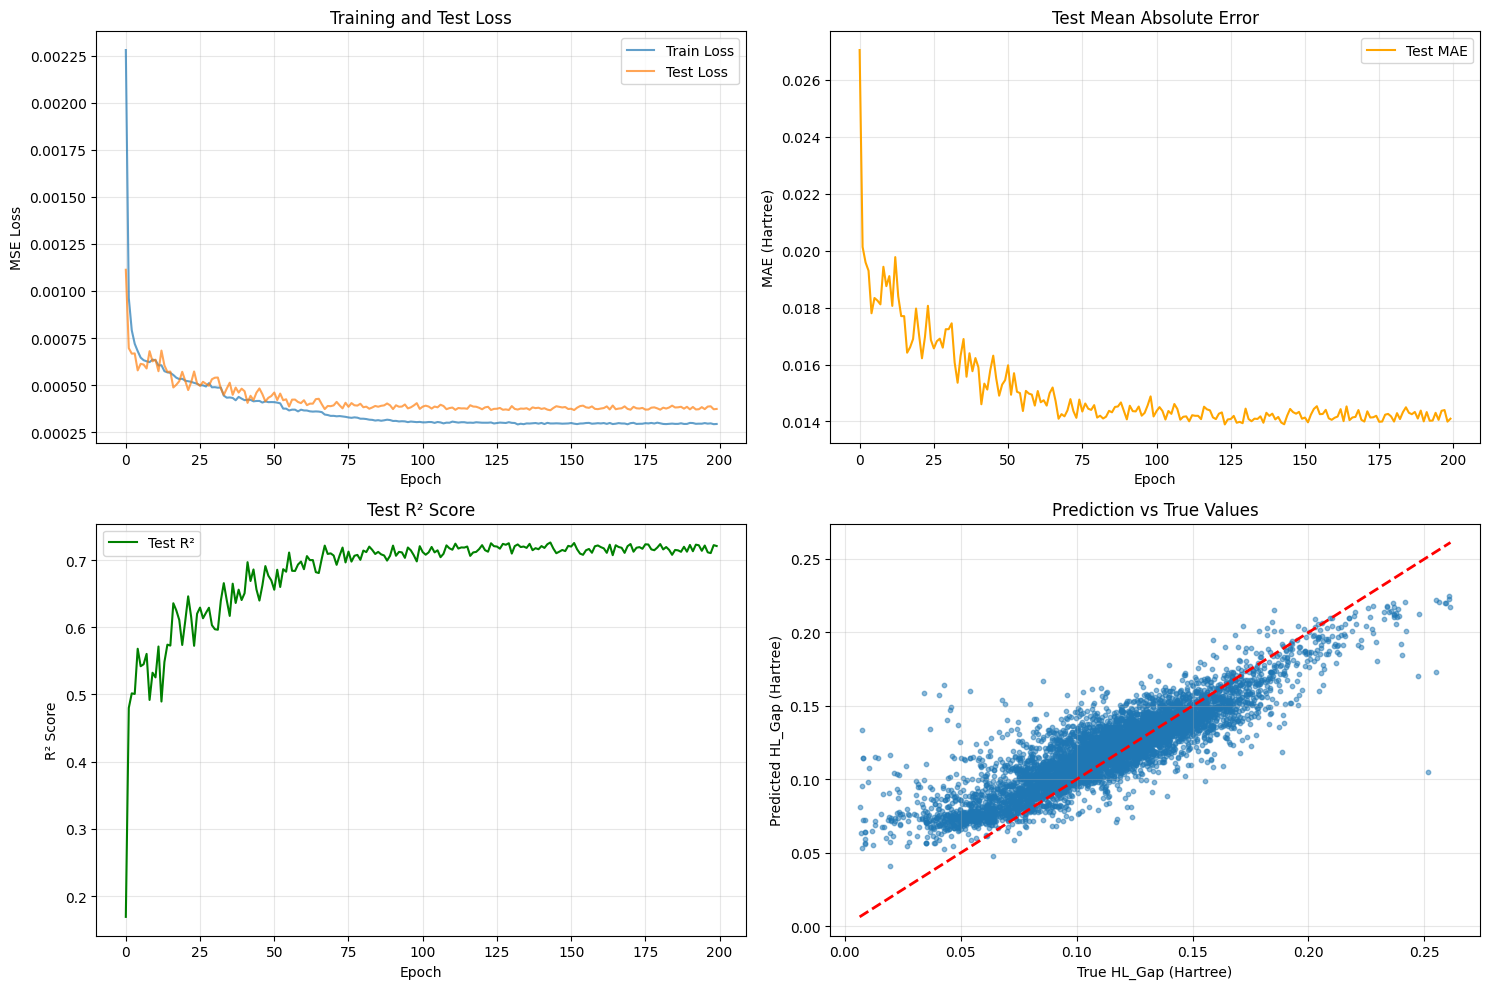


Final Test Results (Best Model):
MAE: 0.0139 Hartree
R²: 0.7250


In [10]:
# 10. 학습 결과 시각화

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', alpha=0.7)
axes[0, 0].plot(test_losses, label='Test Loss', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE curve
axes[0, 1].plot(test_maes, label='Test MAE', color='orange')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE (Hartree)')
axes[0, 1].set_title('Test Mean Absolute Error')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# R² curve
axes[1, 0].plot(test_r2s, label='Test R²', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('Test R² Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Prediction vs True (using best model)
model.load_state_dict(torch.load('best_gnn_model.pt'))
_, _, _, predictions, targets = evaluate(model, test_loader, criterion, device)

axes[1, 1].scatter(targets, predictions, alpha=0.5, s=10)
axes[1, 1].plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', lw=2)
axes[1, 1].set_xlabel('True HL_Gap (Hartree)')
axes[1, 1].set_ylabel('Predicted HL_Gap (Hartree)')
axes[1, 1].set_title('Prediction vs True Values')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gnn_training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Test Results (Best Model):")
print(f"MAE: {mean_absolute_error(targets, predictions):.4f} Hartree")
print(f"R²: {r2_score(targets, predictions):.4f}")

In [11]:
# 11. ALD Precursor 예측

# Load best model
model.load_state_dict(torch.load('best_gnn_model.pt'))
model.eval()

high_k_precursors = {
    'TDMAH': '[N-](C)C->[Hf+4](<-[N-](C)C)(<-[N-](C)C)(<-[N-](C)C)',
    'TEMAH': '[N-](C)CC->[Hf+4](<-[N-](C)CC)(<-[N-](C)CC)(<-[N-](C)CC)',
    'TDEAH': '[N-](CC)CC->[Hf+4](<-[N-](CC)CC)(<-[N-](CC)CC)(<-[N-](CC)CC)',
    'TDMAT': '[N-](C)C->[Ti+4](<-[N-](C)C)(<-[N-](C)C)(<-[N-](C)C)',
    'HfCl4': '[Cl-]->[Hf+4](<-[Cl-])(<-[Cl-])(<-[Cl-])',
    'TiCl4': '[Cl-]->[Ti+4](<-[Cl-])(<-[Cl-])(<-[Cl-])',
    'TTIP': '[O-](C(C)C)->[Ti+4](<-[O-](C(C)C))(<-[O-](C(C)C))(<-[O-](C(C)C))',
    'TDMAZ': '[N-](C)C->[Zr+4](<-[N-](C)C)(<-[N-](C)C)(<-[N-](C)C)',
    'TMA': 'C[Al](C)C',
    'ZrCl4 (Zr)': '[Cl-]->[Zr+4](<-[Cl-])(<-[Cl-])(<-[Cl-])',
}

print("=" * 70)
print("ALD Precursor HL_Gap Predictions (GNN Model)")
print("=" * 70)

precursor_results = {}

with torch.no_grad():
    for name, smiles in high_k_precursors.items():
        graph = smiles_to_graph(smiles)
        if graph is not None:
            graph = graph.to(device)
            graph.batch = torch.zeros(graph.x.shape[0], dtype=torch.long, device=device)
            gap_pred = model(graph).item()
            precursor_results[name] = gap_pred
            print(f"{name:15s}: {gap_pred:.4f} Hartree")
        else:
            print(f"{name:15s}: SMILES 파싱 실패")

print("=" * 70)

# 결과를 정렬하여 표시
print("\nSorted by predicted HL_Gap (ascending):")
print("-" * 70)
for name, gap in sorted(precursor_results.items(), key=lambda x: x[1]):
    print(f"{name:15s}: {gap:.4f} Hartree")
print("=" * 70)

ALD Precursor HL_Gap Predictions (GNN Model)
TDMAH          : 0.1613 Hartree
TEMAH          : 0.1427 Hartree
TDEAH          : 0.1520 Hartree
TDMAT          : 0.1498 Hartree
HfCl4          : 0.1905 Hartree
TiCl4          : 0.1292 Hartree
TTIP           : 0.1888 Hartree
TDMAZ          : 0.1597 Hartree
TMA            : 0.1826 Hartree
ZrCl4 (Zr)     : 0.1670 Hartree

Sorted by predicted HL_Gap (ascending):
----------------------------------------------------------------------
TiCl4          : 0.1292 Hartree
TEMAH          : 0.1427 Hartree
TDMAT          : 0.1498 Hartree
TDEAH          : 0.1520 Hartree
TDMAZ          : 0.1597 Hartree
TDMAH          : 0.1613 Hartree
ZrCl4 (Zr)     : 0.1670 Hartree
TMA            : 0.1826 Hartree
TTIP           : 0.1888 Hartree
HfCl4          : 0.1905 Hartree


ALD Precursor HL_Gap Prediction Performance
MAE  = 0.0289 Hartree
RMSE = 0.0383 Hartree


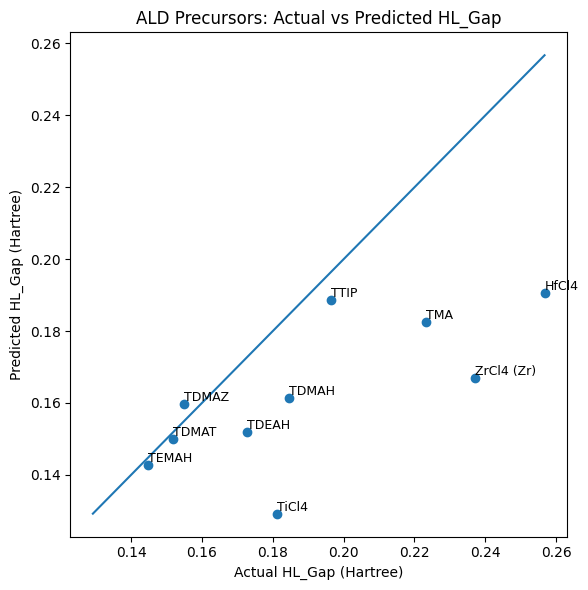

In [12]:
# 12. ALD Precursor 실제값 vs 예측값 스캐터 플롯

import numpy as np
import matplotlib.pyplot as plt

# 1) 실제 계산 밴드갭 값 (Hartree) 입력
actual_gaps = {
    "TDMAH":      0.184442,
    "TEMAH":      0.144798,
    "TDEAH":      0.172795,
    "TDMAT":      0.151902,
    "HfCl4":      0.256719,
    "TiCl4":      0.181093,
    "TTIP":       0.196301,
    "TDMAZ":      0.154910,
    "TMA":        0.223108,
    "ZrCl4 (Zr)": 0.237103,
}

# 2) precursor_results (GNN 예측값) 와 실제값을 공통 key 기준으로 정렬
names = []
actual = []
pred = []

for name, pred_gap in precursor_results.items():
    if name in actual_gaps:
        names.append(name)
        actual.append(actual_gaps[name])
        pred.append(pred_gap)
    else:
        print(f"[경고] 실제값 없음: {name}")

actual = np.array(actual)
pred = np.array(pred)

# 3) 기본 지표 계산 (MAE, RMSE)
errors = pred - actual
mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))

print("=" * 70)
print("ALD Precursor HL_Gap Prediction Performance")
print("=" * 70)
print(f"MAE  = {mae:.4f} Hartree")
print(f"RMSE = {rmse:.4f} Hartree")
print("=" * 70)

# 4) 스캐터 플롯 (실제 vs 예측)
plt.figure(figsize=(6, 6))

# 점 찍기
plt.scatter(actual, pred)

# y = x 기준선 (완벽 예측)
min_val = min(actual.min(), pred.min())
max_val = max(actual.max(), pred.max())
plt.plot([min_val, max_val], [min_val, max_val])

# 각 점에 화합물 이름 라벨 달기
for x, y, name in zip(actual, pred, names):
    plt.text(x, y, name, fontsize=9, ha='left', va='bottom')

plt.xlabel("Actual HL_Gap (Hartree)")
plt.ylabel("Predicted HL_Gap (Hartree)")
plt.title("ALD Precursors: Actual vs Predicted HL_Gap")
plt.tight_layout()
plt.show()
